# Notebook to generate a text file containing recombination values
This notebook uses NESTpy to generate LAr recombination values. It creates a text file with recombination values for input to the larnd-sim_beta-decay fork of larnd-sim.

In [1]:
import nestpy

ModuleNotFoundError: No module named 'nestpy'

In [2]:
%run setup_notebook.py

nestpy version: v2.0.0
NEST version: v2.3.11


In [3]:
# generate R-value for a single energy electron
import nestpy
efield = 500
density = 1.393
energy_test = 5000

larnest = nestpy.LArNEST(nestpy.VDetector())
result = larnest.full_calculation(
    nestpy.LArInteraction.ER,
    energy_test,
    efield,
    density,
    False
)

Nph = result.fluctuations.NphFluctuation
Ne = result.fluctuations.NeFluctuation
print("Nph: ", Nph)
print("Ne: ", Ne)

R = Ne/(Nph + Ne)
print(R)
print(0.602965)

Nph:  99852.86000320682
Ne:  156441.13999679318
0.6103972000780088
0.602965


In [62]:
# calculate average recombination values for an energy range, Efield, and number of events
import numpy as np
num_energy_steps = 6000
start_val = 1
end_val = 6000
num_events = 5000
efield = 500
#step_size = (end_val - start_val) / num_energy_steps
step_size = 1
#energy_vals = [start_val + step_size * ii for ii in range(num_energy_steps)]
energy_vals = np.arange(start_val,end_val+1, step_size)
detector = nestpy.VDetector()
larnest = nestpy.LArNEST(detector)
Nph_all = []
Ne_all = []
for energy_step in energy_vals:
    Nph = np.zeros(num_events)
    Ne = np.zeros(num_events)

    for ii in range(num_events):
        result = larnest.full_calculation(
            nestpy.LArInteraction.ER,
            energy_step,
            efield,
            density,
            False
        )
        Nph[ii] = result.fluctuations.NphFluctuation
        Ne[ii] = result.fluctuations.NeFluctuation
    Nph_mean = np.mean(Nph)
    Ne_mean = np.mean(Ne)

    Nph_std = np.std(Nph) / np.sqrt(num_events)
    Ne_std = np.std(Ne) / np.sqrt(num_events)

    Nph_all.append(Nph_mean)
    Ne_all.append(Ne_mean)

In [ ]:
# save recombination values to a text file for larnd-sim 
recomb = np.array(Ne_all)/(np.array(Ne_all) + np.array(Nph_all))
f = open("NEST_electron-energy_and_recombination-factors_Efield500_1keV_to_6000keV_stepsize1keV.txt","w+")
for i, R in enumerate(recomb):
    E = energy_vals[i]
    f.write(str(E) + ',' + str(R))
    f.write('\n')
f.close()

(0.0, 600.0)

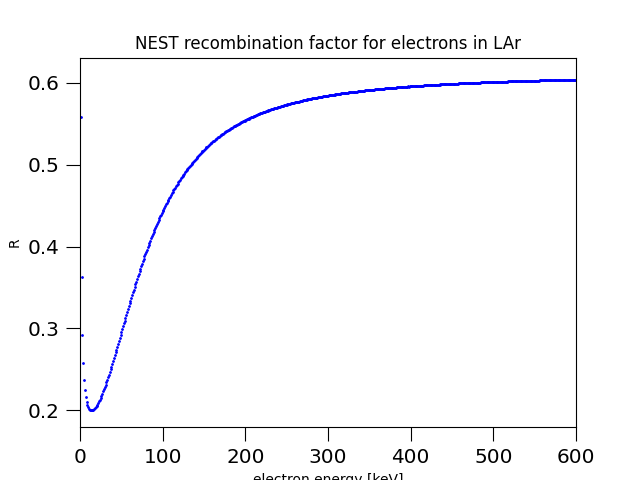

In [5]:
# plot the recombination values
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

filename = "NEST_electron-energy_and_recombination-factors_Efield500_1keV_to_6000keV.txt"
data = np.loadtxt(filename, dtype='float', delimiter=',')
energies = data[:,0]
recombination = data[:,1]

import h5py
dtype = np.dtype([('E_start', 'f4'),('R', 'f4')])
datapoints = np.empty(len(energies), dtype=dtype)
for i in range(len(energies)):
    datapoints[i]['E_start'] = energies[i]
    datapoints[i]['R'] = recombination[i]

filename = "NEST_electron-energy_and_recombination-factors_Efield500_1keV_to_6000keV_stepsize1keV.h5"
with h5py.File(filename, 'w') as f:
    f.create_dataset("NEST", data=datapoints)


#cs = CubicSpline(energies, recombination)
fit_energies = np.arange(np.min(energies), np.max(energies), 0.5)
fit = np.interp(fit_energies, energies, recombination)
%matplotlib widget
#plt.plot(fit_energies, cs(fit_energies), 'r-')
#plt.plot(fit_energies, fit, 'r-')
plt.plot(energies, recombination, 'bo', markersize=1)
plt.xlabel('electron energy [keV]')
plt.ylabel('R')
plt.title('NEST recombination factor for electrons in LAr')
plt.xlim(0,600)